# 区間推定

**区間推定**（interval estimation）は推定したいパラメータ$\theta$の真の値がある区間$(L, U)$に入る確率が$1-\alpha$以上（$\alpha$は$\theta$が区間に入らない確率）になる区間を推定する。つまり、

$$
P(L \leq \theta \leq U) \geq 1 - \alpha
$$

の$L, U$を推定する。

なお、この$1-\alpha$を**信頼係数**（confidence coefficient）といい、区間$[L, U]$を**信頼区間**（confidence interval）と呼ぶ。

## 正規母集団の母平均の区間推定

確率変数$X$の標本平均$\bar{X}$は中心極限定理により正規分布$N(\mu, \sigma^2 / n)$に従う。

これを標準化して

$$
Z = \frac{\bar{X} - \mu}{\sigma / \sqrt{n}}
$$

とすると、これは平均0、標準偏差1の**標準正規分布**に従う。

::::{margin}
:::{card} **標準化**（standardization）
ある確率変数$X$から、その変数の平均$\mu$を引いて標準偏差$\sigma$で割る操作のこと。

$$
z = \frac{X - \mu}{\sigma}
$$

これは線形変換であり、分布形状を変えずに平均を0、標準偏差を1に揃えることができる。**Zスコア**と呼ばれることもある。
:::
::::

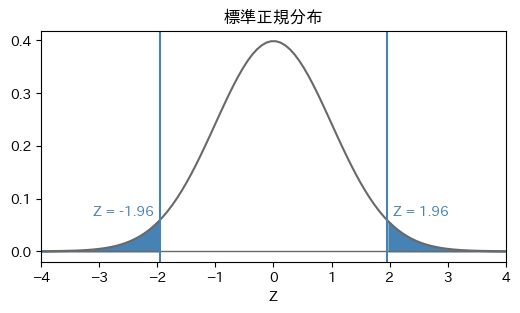

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import japanize_matplotlib
from scipy.stats import norm

z = np.linspace(-4, 4, 100)
y = norm.pdf(z)

fig, ax = plt.subplots(dpi=100, figsize=[6, 3])
ax.set(title="標準正規分布", xlabel="Z", xlim=(-4, 4))
ax.plot(z, y, color="dimgray")
ax.axhline(y=0, color="dimgray", linewidth=1)

alpha = 0.05 / 2
for a in [alpha, (1 - alpha)]:
    x = norm.ppf(a)
    ax.axvline(x=x, color="steelblue")
    if x < 0:
        ax.text(x - 0.1, norm.pdf(x) + 0.01, f"Z = {x:.2f}", color="steelblue", horizontalalignment="right")
        ax.fill_between(z, 0, y, where = z <= x, color="steelblue")
    else:
        ax.text(x + 0.1, norm.pdf(x) + 0.01, f"Z = {x:.2f}", color="steelblue", horizontalalignment="left")
        ax.fill_between(z, 0, y, where = z >= x, color="steelblue")


標準正規分布は$(-\infty, \infty)$の範囲にわたって確率密度関数がゼロでない領域が存在するが、図のように正規分布の両端でそれぞれ確率$\alpha/2$分だけ推定を誤る可能性を許容すると、一定の範囲で区切ることができる。図は$\alpha=0.05$として、両側それぞれでその半分の確率$\alpha / 2 = 0.025$の領域で区切っており、それに相当する$Z$の値が$Z \pm 1.96$である。

一般化してこのような値を$Z_{\alpha/2}$と表すことにすると、区間推定は

$$
P(-Z_{\alpha/2} \leq \frac{\sqrt{n} (\bar{X} - \mu)}{\sigma} \leq Z_{\alpha/2}) = 1 - \alpha
$$

となり、これを$\mu$について解くと

$$
P(\bar{X} - Z_{\alpha/2} \times \frac{\sigma}{\sqrt{n}}
  \leq \mu \leq 
  \bar{X} + Z_{\alpha/2} \times \frac{\sigma}{\sqrt{n}}) = 1 - \alpha
$$

であり、信頼区間は

$$
[\bar{X} - Z_{\alpha/2} \times \frac{\sigma}{\sqrt{n}},
 \bar{X} + Z_{\alpha/2} \times \frac{\sigma}{\sqrt{n}}]
$$

となる。


### pythonでの実装

母集団が$[0, 1]$の範囲の値をとる一様分布$U(0, 1)$（母平均$\mu=\frac{0+1}{2} = 0.5$）であるとし、そこから得た次のようなサンプルがあるとする。

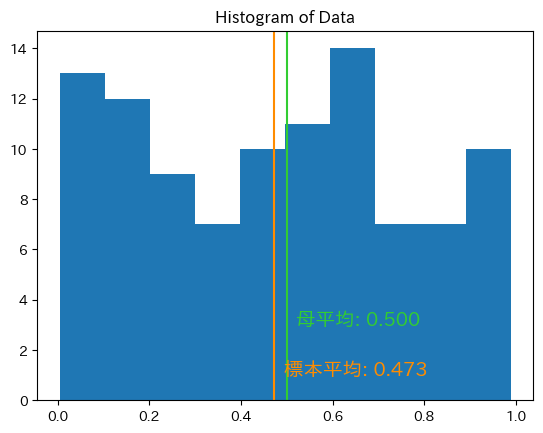

In [10]:
np.random.seed(0)

n = 100
x = np.random.uniform(low=0, high=1, size=n)
mu = 0.5  # 母平均

fig, ax = plt.subplots()
ax.hist(x)
ax.set(title="Histogram of Data")
ax.axvline(x.mean(), color="darkorange")
ax.text(x.mean() + 0.02, 1, f"標本平均: {x.mean():.3f}", color="darkorange", size=14)
ax.axvline(mu, color="limegreen")
ax.text(mu + 0.02, 3, f"母平均: {mu:.3f}", color="limegreen", size=14)
fig.show()

式をpythonに落とし込んで計算すると次のようになる

In [11]:
# ※ddof=1: 不偏標準偏差にするためのオプション
std_error = x.std(ddof=1) / np.sqrt(n)

# 信頼区間
alpha = 0.05
z = norm.ppf(1 - alpha / 2)
[x.mean() - z * std_error, x.mean() + z * std_error]

[0.4160030960878336, 0.5295845829372018]

`statsmodels`の`emplike.DescStat`で計算することもできる

In [12]:
# statsmodelsを使う場合
from scipy.stats import norm
import statsmodels.api as sm
el = sm.emplike.DescStat(x)
el.ci_mean()

(0.4166429503391242, 0.5294769896986984)

`scipy.stats` の `norm.interval()` で計算することもできる。

In [4]:
from scipy.stats import norm, sem
norm.interval(confidence=0.95, loc=x.mean(), scale=sem(x))
# ※ sem は standard error of mean、つまり x.std(ddof=1) / np.sqrt(n)と等しい

(0.4160030960878336, 0.5295845829372018)

サンプルをとって95%信頼区間を計算する作業を100回繰り返したものが以下の図である。$\alpha=0.05$なので、100回の調査で5回程度は推定を誤る（信頼区間に母平均が含まれない）可能性がある。

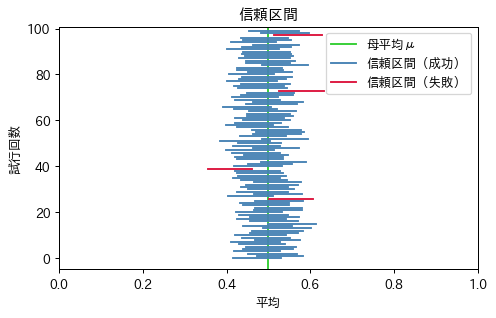

In [5]:
np.random.seed(0)

fig, ax = plt.subplots(dpi=90, figsize=[6, 3.5])
ax.set(title="信頼区間", xlabel="平均", ylabel="試行回数")
ax.axvline(mu, color="limegreen", label="母平均μ")

is_first_success = True
is_first_fail = True
n_trial = 100
for i in range(n_trial):
    x = np.random.uniform(size=n)
    lower, upper = norm.interval(confidence=0.95, loc=x.mean(), scale=sem(x))
    args = dict(y=i, xmin=lower, xmax=upper)

    if mu < lower or upper < mu:
        # 凡例表示のため初回だけlabelをつける
        if is_first_fail:
            ax.axhline(**args, color="crimson", label="信頼区間（失敗）")
            is_first_fail = False
        else:
            ax.axhline(**args, color="crimson")
    else:
        if is_first_success:
            ax.axhline(**args, color="steelblue", label="信頼区間（成功）")
            is_first_success = False
        else:
            ax.axhline(**args, color="steelblue")

ax.legend()
fig.show()

## $t$検定

母分散が未知の場合、$t$分布を用いる。標本標準偏差を$s$とすると、

$$
t = \sqrt{n} \frac{ \bar{X} - \mu }{ s }
$$

は自由度$n-1$の$t$分布に従うため、

$$
P\left(
    \bar{X} - t_{\alpha/2}(n-1) \times \frac{s}{\sqrt{n}}
    \leq \mu \leq
    \bar{X} + t_{\alpha/2}(n-1) \times \frac{s}{\sqrt{n}}
\right)
= 1 - \alpha
$$

となる。